In [0]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns

In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
df = pd.read_csv('/content/gdrive/My Drive/NLP/Womens Clothing E-Commerce Reviews.csv')

In [0]:
for column in ["Division Name","Department Name","Class Name","Review Text"]:
    df = df[df[column].notnull()]
df.drop(df.columns[0], inplace=True, axis=1)

In [0]:
df.shape

(22628, 10)

In [0]:
df['Word Count'] = df['Review Text'].str.split().apply(len)

In [0]:
df.sample(3)

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name,Word Count
23051,643,44,Amazing!,I can't say enough about this jumpsuit. within...,5,1,1,General,Trend,Trend,29
10694,1083,25,This dress makes me look 20 years younger,I disagree with reviewers who said the dress l...,5,1,2,General,Dresses,Dresses,94
10781,864,62,Feminine and pretty!,Love this top. have two of them. they are comf...,5,1,0,General,Tops,Knits,15


In [0]:
df.loc[df['Recommended IND'] == 0].shape

(4101, 11)

### Recommendation

In [0]:
reviews = df['Review Text'].astype(str).str.lower()

In [0]:
type(reviews)

pandas.core.series.Series

In [0]:
features = reviews.tolist()

In [0]:
features[:3]

['absolutely wonderful - silky and sexy and comfortable',
 'love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.',
 'i had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c']

In [0]:
import re # Provide regular expression matching operations
from string import punctuation

In [0]:
for index in range(len(features)):
    all_text = ''.join([character for character in features[index] if character not in punctuation]) # Remove punctuation and join remaining characters
    features[index] = re.split(r'\n|\r', all_text) # Remove newline or carriage return
    features[index] = ' '.join([word for word in features[index]])

一个叫做“回车” `\r`，告诉打字机把打印头定位在左边界；另一个叫做“换行” `\n`，告诉打字机把纸向下移一行。

\\

Unix系统里，每行结尾只有`\n`；Windows系统里面，每行结尾是`\n\r`；Mac系统里，每行结尾是`\r`。一个直接后果是，Unix/Mac系统下的文件在Windows里打开的话，所有文字会变成一行；而Windows里的文件在Unix/Mac下打开的话，在每行的结尾可能会多出一个^M符号。

\\

c++语言编程时（windows系统）, `\r` 就是return 回到 本行 行首 这就会把这一行以前的输出 覆盖掉, 如：
```
int main() {

cout << "hahaha" << "\r" << "xixi"}
``` 
最后只显示 xixi 而 hahaha 背覆盖了

\\

`\n`  是回车＋换行 把光标 先移到 行首 然后换到下一行 也就是下一行的行首拉

```
int main() {

cout << "hahaha" << "\n" << "xixi" }
```
则 显示
```
hahaha
xixi```

In [0]:
features[:3]

['absolutely wonderful  silky and sexy and comfortable',
 'love this dress  its sooo pretty  i happened to find it in a store and im glad i did bc i never would have ordered it online bc its petite  i bought a petite and am 58  i love the length on me hits just a little below the knee  would definitely be a true midi on someone who is truly petite',
 'i had such high hopes for this dress and really wanted it to work for me i initially ordered the petite small my usual size but i found this to be outrageously small so small in fact that i could not zip it up i reordered it in petite medium which was just ok overall the top half was comfortable and fit nicely but the bottom half had a very tight under layer and several somewhat cheap net over layers imo a major design flaw was the net over layer sewn directly into the zipper  it c']

In [0]:
labels = np.array(df['Recommended IND'], np.int)

In [0]:
labels.shape

(22628,)

In [0]:
labels[labels == 1].shape[0]

18527

In [0]:
labels[labels == 0].shape[0]

4101

In [0]:
from keras.utils import to_categorical # Convert a class vector (integers) to binary class matrix.

Using TensorFlow backend.


In [0]:
labels = to_categorical(labels)

In [0]:
labels[:10]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [0]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [0]:
t = Tokenizer()
t.fit_on_texts(features) # 将输入的文本中的每个词编号，编号是根据词频的，词频越大，编号越小
vocabulary_size = len(t.word_index) + 1 # word_index 每个词的编号

In [0]:
print('Vocabulary size : {}'.format(vocabulary_size))

Vocabulary size : 19370


In [0]:
encoded_features = t.texts_to_sequences(features) # 将文字转化成数字列表，使用每个词的编号进行编号

max_length = 300

padded_features = pad_sequences(encoded_features, maxlen=max_length, padding='post') # 将每条评论的长度设置一个固定值

In [0]:
embeddings_index = dict()
with open('/content/gdrive/My Drive/NLP/glove.840B.300d.txt') as file:
    data = file.readlines()
    
# store <key, value> pair of FastText vectors
for line in data[1:]:
    word, vec = line.split(' ', 1)
    embeddings_index[word] = np.array([float(index) for index in vec.split()], dtype='float32')
print('Loaded {} word vectors.'.format(len(embeddings_index)))


embedding_matrix = np.zeros((vocabulary_size, max_length))
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 2196016 word vectors.


In [0]:
words = []
for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        words.append(word)

In [0]:
print('{} words covered.'.format(len(words)))


13911 words covered.


In [0]:
def train_test_split(features, labels, **kwargs):
    
    # concatenate the features and labels array
    dataset = np.c_[features, labels]

    # shuffle the dataset
    np.random.shuffle(dataset)

    # split the dataset into features, labels
    features, labels = dataset[:, 0:max_length], dataset[:, max_length:]

    # get the split size for training dataset
    split_index = int(kwargs['train_size'] * len(features))

    # split the dataset into training/validation dataset
    train_features, validation_features = features[:split_index], features[split_index:]
    train_labels, validation_labels = labels[:split_index], labels[split_index:]

    # get the split size for validation dataset
    split_index = int(kwargs['validation_size'] * len(validation_features))

    # split the validation dataset into validation/testing dataset
    validation_features, test_features = validation_features[:split_index], validation_features[split_index:]
    validation_labels, test_labels = validation_labels[:split_index], validation_labels[split_index:]

    # return the partitioned dataset
    return [train_features, train_labels], [validation_features, validation_labels], [test_features, test_labels]

In [0]:
train_dataset, validation_dataset, test_dataset = train_test_split(features=padded_features, labels=labels,
                                                                   train_size=0.60, validation_size=0.50)

In [0]:
print('Dataset size : {}'.format(padded_features.shape[0]))
print('Train dataset size : {}'.format(train_dataset[0].shape[0]))
print('Validation dataset size : {}'.format(validation_dataset[0].shape[0]))
print('Test dataset size : {}'.format(test_dataset[0].shape[0]))

Dataset size : 22628
Train dataset size : 13576
Validation dataset size : 4526
Test dataset size : 4526


In [0]:
from keras import callbacks
from keras.layers import Bidirectional
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.model_selection import StratifiedKFold

In [0]:
model = Sequential()
e = Embedding(vocabulary_size, max_length,
              weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(Bidirectional(LSTM(256)))
model.add(Dropout(0.50))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(train_dataset[0], train_dataset[1], epochs=32, batch_size=256, verbose=1,
          validation_data=(validation_dataset[0], validation_dataset[1]))

score = model.evaluate(test_dataset[0], test_dataset[1], verbose=1)

print('loss : {}, acc : {}'.format(score[0], score[1]))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 13576 samples, validate on 4526 samples
Epoch 1/32
13576/13576 [==============================] - 81s 6ms/step - loss: 0.4666 - acc: 0.8154 - val_loss: 0.4404 - val_acc: 0.8111
Epoch 2/32
13576/13576 [==============================] - 78s 6ms/step - loss: 0.4453 - acc: 0.8208 - val_loss: 0.4472 - val_acc: 0.8016
Epoch 3/32
13576/13576 [==============================] - 78s 6ms/step - loss: 0.3595 - acc: 0.8393 - val_loss: 0.3480 - val_acc: 0.8496
Epoch 4/32
13576/13576 [==============================] - 79s 6ms/step - loss: 0.3440 - acc: 0.8480 - val_loss: 0.3110 - val_acc: 0.8658
Epoch 5/32
13576/13576 [==============================] - 79s 6ms/step - loss: 0.2974 - acc: 0.8726 - val_loss: 0.2863 - val_acc: 0.8682
Epoch 6/32
13576/13576 [=======

In [0]:
import pickle
pkl_filename = "/content/gdrive/My Drive/NLP/RNN_Recommended.pkl"  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(model, file)

In [0]:
test_dataset[1][0]

array([1., 0.])

In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

test_predictions = model.predict(test_dataset[0])
test_predictions = np.argmax(test_predictions, axis=1)

class_names = ['(0) Not recommended class', '(1) Recommended class']
report = classification_report(np.argmax(test_dataset[1], axis=1), test_predictions, target_names=class_names)

In [0]:
print(report)

                           precision    recall  f1-score   support

(0) Not recommended class       0.72      0.68      0.70       828
    (1) Recommended class       0.93      0.94      0.94      3698

                micro avg       0.89      0.89      0.89      4526
                macro avg       0.82      0.81      0.82      4526
             weighted avg       0.89      0.89      0.89      4526



In [0]:
conf_matrix = confusion_matrix(np.argmax(test_dataset[1], axis=1), test_predictions)
print(conf_matrix)

[[ 567  261]
 [ 221 3477]]


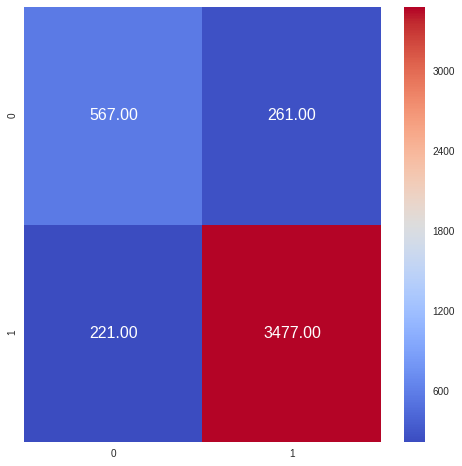

In [0]:
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, annot_kws={'size': 16}, cmap='coolwarm', fmt='.2f')
plt.savefig('conf_matrix_recommendation.png', format='png', dpi=300)

In [0]:
from sklearn.metrics import roc_auc_score

roc = roc_auc_score(y_score=test_predictions, y_true=np.argmax(test_dataset[1], 1))
print(roc)

0.8125102875820067


In [0]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(np.argmax(test_dataset[1], 1), test_predictions)
roc_auc = auc(fpr, tpr)
print(roc_auc)

0.8125102875820067


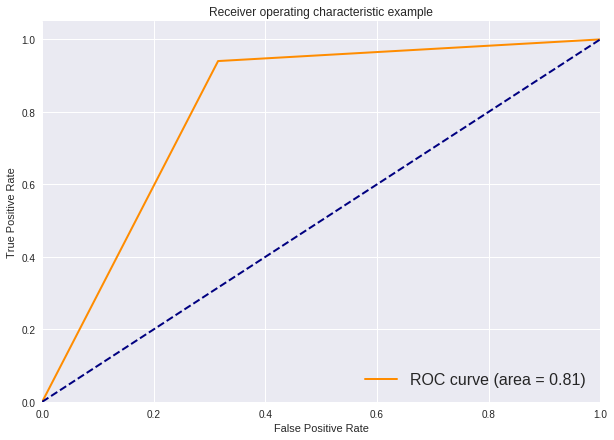

In [0]:
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, lw=2, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc='lower right', fontsize=16)
plt.savefig('roc.png', format='png', dpi=300)
plt.show()